<a href="https://colab.research.google.com/github/rahiakela/practical-machine-learning-with-tensorflow/blob/week-5/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

This tutorial shows how to classify cats or dogs from images. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly-gpu-2.0-preview
except Exception:
  pass
import tensorflow as tf

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Begin by downloading the dataset. This tutorial uses a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from Kaggle. Download the archive version of the dataset and store it in the "/tmp/" directory.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 1s 0us/step


The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')            # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')            # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understand the data

Let's look at how many cats and dogs images are in the training and validation directory:

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

### Preprocessing

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [0]:
train_image_generator = ImageDataGenerator(rescale=1. / 255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1. / 255)  # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary'
                                                           )

Found 2000 images belonging to 2 classes.


In [11]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [0]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

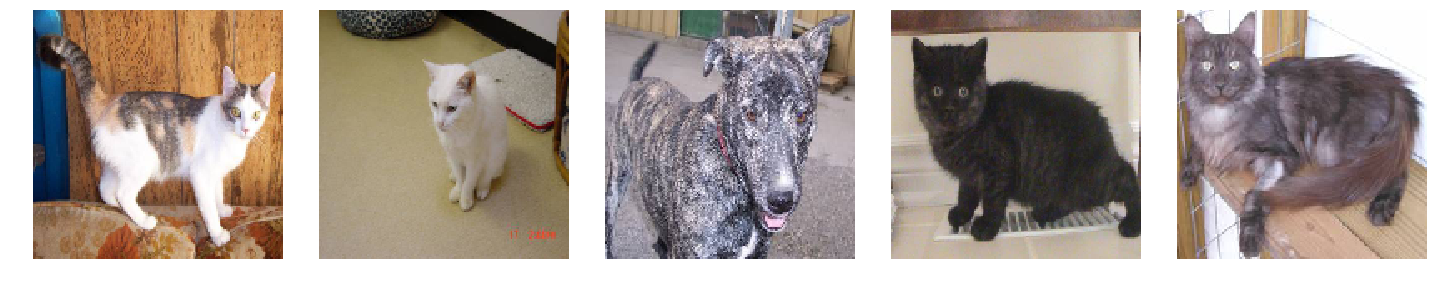

In [14]:
plotImages(sample_training_images[:5])

## Create the model

### Create model architecture

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it thatr is activated by a `relu` activation function. The model outputs class probabilities based on binary classification by the `sigmoid` activation function.

In [0]:
model = Sequential([
   Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   MaxPooling2D(),
   Conv2D(32, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Conv2D(64, 3, padding='same', activation='relu'),   
   MaxPooling2D(),
   Flatten(),
   Dense(512, activation='relu'),
   Dense(1, activation='sigmoid')              
])

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=total_train // batch_size,
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=total_val // batch_size)

Epoch 1/15
15/15 [==============================] - 11s 761ms/step - loss: 0.9305 - accuracy: 0.4808 - val_loss: 0.6888 - val_accuracy: 0.5770
Epoch 2/15
15/15 [==============================] - 10s 646ms/step - loss: 0.6795 - accuracy: 0.5721 - val_loss: 0.6620 - val_accuracy: 0.6060
Epoch 3/15
15/15 [==============================] - 10s 647ms/step - loss: 0.6508 - accuracy: 0.6271 - val_loss: 0.6274 - val_accuracy: 0.6775
Epoch 4/15
15/15 [==============================] - 10s 646ms/step - loss: 0.5868 - accuracy: 0.6979 - val_loss: 0.5917 - val_accuracy: 0.6830
Epoch 5/15
15/15 [==============================] - 10s 638ms/step - loss: 0.5403 - accuracy: 0.7420 - val_loss: 0.6164 - val_accuracy: 0.6551
Epoch 6/15
15/15 [==============================] - 10s 635ms/step - loss: 0.5192 - accuracy: 0.7409 - val_loss: 0.5633 - val_accuracy: 0.7020
Epoch 7/15
15/15 [==============================] - 10s 637ms/step - loss: 0.4961 - accuracy: 0.7577 - val_loss: 0.5890 - val_accuracy: 0.6931

### Visualize training results

Now visualize the results after training the network.

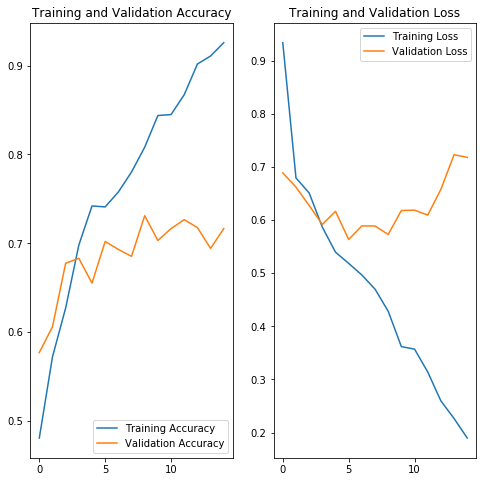

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

Let's look at what went wrong and try to increase overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to our model.